In [103]:
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
discountrate = 0.04
WACC = 0.05

teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'

In [105]:
def calculate_present_value(future_value, year, base_year, discount_rate=discountrate):
    return future_value / ((1 + discount_rate) ** (year - base_year))

def calculate_annuity(n, r):
    if n == 0:
        return 1
    return r / (1 - ((1 + r) ** -n))

def empire_factor(period,lifetime):
    return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)

costs = pd.read_csv('C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/data/costs.csv')
costs_pivot = costs.pivot(index='technology', columns='parameter', values='value')
costs_pivot['FOM'].fillna(0, inplace=True)
capital_cost_df = pd.DataFrame()

# List of technologies
old_techs = ['OCGT', 'CCGT', 'biomass', 'oil', 'onwind', 'solar', 'ror', 'hydro', 'geothermal', 'battery storage', 'battery inverter', 'HVAC overhead']
for tech in old_techs:
    if tech in costs_pivot.index:
        lifetime = costs_pivot.at[tech, 'lifetime']
        FOM = costs_pivot.at[tech, 'FOM']
        investment = costs_pivot.at[tech, 'investment']

        annuity_factor = calculate_annuity(lifetime, WACC)
        annual_cost = (annuity_factor + FOM / 100.0) * investment

        new_row = pd.DataFrame({'capital_cost': [annual_cost * 1e3]}, index=[tech])
        capital_cost_df = pd.concat([capital_cost_df, new_row])

C:\Users\noraky\AppData\Local\Temp\ipykernel_25656\1633671001.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  costs_pivot['FOM'].fillna(0, inplace=True)


In [106]:
years = [2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039]
capacity = pd.DataFrame(index=years)

installed = [100, 100, 0, 0, 100, 100, 0, 0, 50, 50, 0, 0, 50, 0, 500]

for y, value in zip(years, installed):
    capacity.at[y, 'CCGT'] = value

In [107]:
# First method

capital_costs_1 = []
accumulated_new_cap = []

gen_capex_empire = 0
bat_capex_empire = 0
line_capex_empire = 0

for y in years:
    total_capex = 0

    for carrier in capacity.columns:
        accumulated_new_cap = capacity.loc[: y, carrier].sum()
        total_capex += accumulated_new_cap *  capital_cost_df.loc[carrier, 'capital_cost']


    capital_costs_1.append(total_capex/1e6)

pv_capital_costs_1 = [calculate_present_value(i, year, years[0], discountrate) for i, year in zip(capital_costs_1, years)]

In [108]:
# Second method

def empire_factor(y,lifetime):
    return (1-(1+discountrate)**-min((years[-1]-y+1,lifetime)))/(1-(1+discountrate)**-1)

capital_costs_2 = []

for y in years:
    gen_capex = 0

    for carrier in capacity.columns:
        empire_factor_value = empire_factor(y, costs_pivot.at[carrier, 'lifetime'])
        capex_value = capacity.loc[y, carrier] * capital_cost_df.loc[carrier, 'capital_cost'] * empire_factor_value
        gen_capex += capex_value

    capital_costs_2.append(gen_capex/1e6)



pv_capital_costs_2 = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(capital_costs_2, years)]


In [109]:
# Third method

def empire_factor(period,lifetime):
    return (1-(1+discountrate)**-min((3-period+1)*5,lifetime))/(1-(1+discountrate)**-1)

capital_costs_3 = []


capital_cost_by_type = []
period = 1

for y in years:

    if y == 2025 or y == 2030 or y == 2035:
        gen_capex = 0

    if 2029 < y < 2035:
        period = 2
    elif y >= 2035:
        period = 3

    for carrier in capacity.columns:
        empire_factor_value = empire_factor(period, costs_pivot.at[carrier, 'lifetime'])
        capex_value = capacity.loc[y, carrier] * capital_cost_df.loc[carrier, 'capital_cost'] * empire_factor_value
        gen_capex += capex_value


    if y == 2029 or y == 2034 or y == 2039:
        capital_costs_3.append((gen_capex)/1e6)
        for i in range(4):
            capital_costs_3.append(0)

pv_capital_costs_3 = [calculate_present_value(i, year, years[0], 0.04) for i, year in zip(capital_costs_3, years)]


In [110]:
print('First method: ', sum(capital_costs_1), sum(pv_capital_costs_1))
print('Second method: ', sum(capital_costs_2), sum(pv_capital_costs_2))
print('Third method: ', sum(capital_costs_3), sum(pv_capital_costs_3))

First method:  453.85923280459394 322.9743501148855
Second method:  377.3877349370394 322.9743501148851
Third method:  554.8930220735674 473.73305468470807


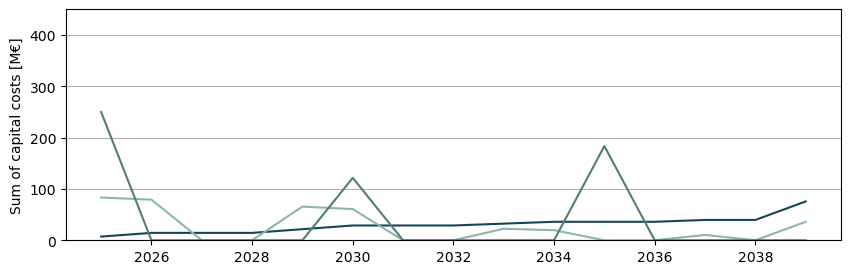

In [111]:
plt.figure(figsize=(10, 3))
plt.ylabel('Sum of capital costs [M€]')
plt.plot(years, capital_costs_1, label='PyPSA OG', color=teal2)
plt.plot(years, capital_costs_2, label='PyPSA Compare', color=teal4)
plt.plot(years, capital_costs_3, label='Empire', color=teal3)
plt.ylim(0, 450)
plt.grid(axis='y')
plt.show()

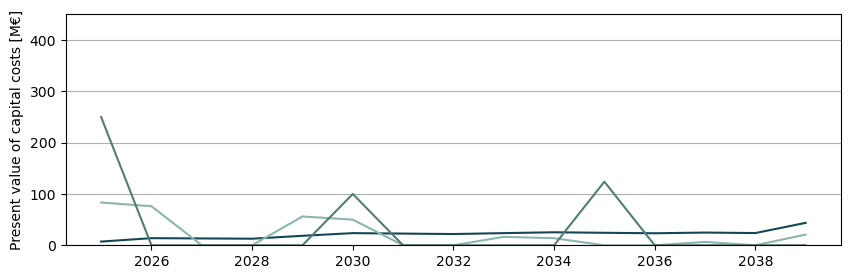

In [112]:
plt.figure(figsize=(10, 3))
plt.ylabel('Present value of capital costs [M€]')
plt.plot(years, pv_capital_costs_1, label='PyPSA OG', color=teal2)
plt.plot(years, pv_capital_costs_2, label='PyPSA Compare', color=teal4)
plt.plot(years, pv_capital_costs_3, label='Empire', color=teal3)
plt.ylim(0, 450)
plt.grid(axis='y')
plt.show()